In [45]:
include("../../src/WaterLily.jl")
WaterLily = Main.WaterLily;
using Plots; gr()
using StaticArrays
using JLD
using Images
using FFTW
using Statistics
using Interpolations
using DelimitedFiles
using LinearAlgebra

%%html
<style>
    .output {
        overflow: hidden;
    }
</style>

In [ ]:
computationID = "ThreeDVortex_256"


In [ ]:
inside(a::AbstractArray) = CartesianIndices(map(ax->first(ax)+1:last(ax)-1,axes(a)))
@inline CI(a...) = CartesianIndex(a...)
"""
    δ(i,N::Int)
    δ(i,I::CartesianIndex{N}) where {N}

Return a CartesianIndex of dimension `N` which is one at index `i` and zero elsewhere.
"""
δ(i,::Val{N}) where N = CI(ntuple(j -> j==i ? 1 : 0, N))
δ(i,I::CartesianIndex{N}) where N = δ(i, Val{N}())
@inline inside_u(dims::NTuple{N}) where N = CartesianIndices((map(i->(2:i-1),dims)...,1:N))

In [ ]:
animAlpha(i,numFiles;y0 = 0.01) = 4*(1-y0)*(i/numFiles-0.5)^3 + (1+y0)/2
animAlpha(i,numFiles;y0 = 0.1) = (1-y0)*(i/numFiles)^2+y0
function movmean(x::Vector{Float64}, m::Integer)
    """Compute off-line moving average
    
    Parameters
    ----------
    x (Array):
        One-dimensional array with time-series. size(x)=(N,)
    m (int):
        Length of the window where the mean is computed
    
    Returns
    -------
    y (Array):
        Array with moving mean values. size(y)=(N-m+1)    
    """

    N = length(x)
    y = fill(0., N-m+1)

    y[1] = sum(x[1:m])/m
    for i in 2:N-m+1
        @views y[i] = y[i-1] + (x[i+m-1]-x[i-1])/m
    end
    return y
end

In [ ]:
function InterpolOmega(xOrig,omega)
    x = xOrig .+ 2.0
    floorx = floor.(x)
    I = CartesianIndex(Int.(floorx)...)
    residual = x.-floorx
    N = length(I)
    s = 0.0
    for i ∈ N
        s += omega[I]*(1-residual[i]) + omega[I+δ(i,I)]*residual[i]
    end
    return s/N
end

function getCylUCoord(rList, thetaList, zList, center)
    return permutedims(
        stack(
            [[a*cos(b)+center[1], a*sin(b)+center[2], c] for a in rList, b in thetaList, c in zList]
        ), 
        [2,3,4,1]
    )
end

function getCylUCylCoord(rList, thetaList, zList, center)
    return [a for a in rList, b in thetaList, c in zList], [b for a in rList, b in thetaList, c in zList], [c for a in rList, b in thetaList, c in zList]
end

function InterpolCylU!(uCylAtCarte, uCylAtCyl, xCylAtCyl)
    x = xCylAtCyl
    carteSize = size(uCylAtCarte)[1:3]
    uSize = size(xCylAtCyl)
    N = last(uSize)
    insize = Base.front(uSize)
    s = Vector([0.0,0.0,0.0])
    for ixyz∈CartesianIndices(insize)
        regularizedCoord = mod.(x[ixyz,:], carteSize)
        floorCoord = floor.(regularizedCoord.+0.5) .- 0.5
        aaa = deepcopy(floorCoord)
        residual = regularizedCoord.-floorCoord
        floorCoord = mod.(floorCoord, carteSize)
        I = CartesianIndex(Int.(round.(floorCoord.+0.5))...)
        s .= 0.0
        for i ∈ N
            Iup = CartesianIndex(mod.((I+δ(i,I)).I .-1, carteSize) .+1)
            s += uCylAtCarte[I,:]*(1-residual[i]) + uCylAtCarte[Iup,:]*residual[i]
        end
        uCylAtCyl[ixyz,:] .= s/N
    end
end

function InterpolCylUPkg!(uOriginalAll, uCylAtCyl, xCylAtCyl)
    x = xCylAtCyl
    carteSize = size(uOriginalAll)[1:3] .- 2
    itpUx = interpolate(uOriginalAll[:,:,:,1], BSpline(Linear()))
    itpUy = interpolate(uOriginalAll[:,:,:,2], BSpline(Linear()))
    itpUz = interpolate(uOriginalAll[:,:,:,3], BSpline(Linear()))
    uSize = size(xCylAtCyl)
    N = last(uSize)
    insize = Base.front(uSize)
    for ixyz∈CartesianIndices(insize)
        regularizedCoord = mod.(x[ixyz,:], carteSize) .+ 1.5
        uCylAtCyl[ixyz,1] = itpUx(regularizedCoord...)
        uCylAtCyl[ixyz,2] = itpUy(regularizedCoord...)
        uCylAtCyl[ixyz,3] = itpUz(regularizedCoord...)
    end
end

In [ ]:
function ComputeVorticity!(u, vortVec)
    for I∈inside(vortVec[:,:,:,1]) 
        vortVec[I,:] = WaterLily.ω(I,u)
    end
    WaterLily.BCPerVec!(vortVec)
end

function ComputeEntrophySpectrum!(vortVec, vortSpectrum)
    vortSpectrum .= 0.0
    magSlice = dropdims(Statistics.mean(vortVec, dims=3),dims=3)
    gridSize = size(magSlice)[1:2]
    ω̂ = magSlice*0im
    for i ∈ 1:3
        ω̂[:,:,i] = fft(magSlice[:,:,i])/prod(gridSize);
    end
    lx = fftfreq(gridSize[1],gridSize[1])
    ly = fftfreq(gridSize[2],gridSize[2])
    count = vortSpectrum*0
    for I in CartesianIndices(gridSize)
        l = sqrt(lx[I[1]]^2+ly[I[2]]^2)
        (l<0.5) && continue
        vortSpectrum[Int(round(l))] += sum(abs2.(ω̂[I,:]))
        count[Int(round(l))] += 1
    end
    vortSpectrum .*= (1:size(vortSpectrum)[1]).^2 ./ count
    vortSpectrum .+=1e-14
end

function ComputeSpectrumFromCylindrical!(uCylFlucAtCyl, rList, axialLength, flucSpectrum, counts)
    flucSpectrum .= 0.0
    cylGridSize = size(uCylFlucAtCyl)[1:3]
    for iRSlice ∈ 1:cylGridSize[1]
        extractedSlice = uCylFlucAtCyl[iRSlice,:,:,:]
        ω̂ = extractedSlice*0im
        for i ∈ 1:3
            ω̂[:,:,i] = fft(extractedSlice[:,:,i])/prod(cylGridSize[2:3]);
        end
        ltheta = fftfreq(cylGridSize[2],rList[iRSlice]*2pi)
        lz = fftfreq(cylGridSize[3],axialLength)
        count = flucSpectrum[:,iRSlice]*0
        vortSpectrum = flucSpectrum[:,iRSlice]*0
        for I in CartesianIndices(cylGridSize[2:3])
            l = sqrt(ltheta[I[1]]^2+lz[I[2]]^2)
            (l<0.5) && continue
            vortSpectrum[Int(round(l))] += sum(abs2.(ω̂[I,:]))
            #vortSpectrum[Int(round(l))] += abs2.(ω̂[I,2])
            count[Int(round(l))] += 1
        end
        clamp!(count,1,Inf)
        vortSpectrum .*= (1:size(vortSpectrum)[1]).^2 ./ count
        vortSpectrum .+= 1e-16
        flucSpectrum[:,iRSlice] = vortSpectrum
        counts[:,iRSlice] = count
    end
end

function ComputeSpectrumFromCylindricalOneD!(uCylFlucAtCyl, rList, axialLength, flucSpectrum, counts)
    flucSpectrum .= 0.0
    cylGridSize = size(uCylFlucAtCyl)[1:2]
    uCylFlucAtCylAvgAxial = dropdims(Statistics.mean(uCylFlucAtCyl, dims=[3]), dims=3)
    for iRSlice ∈ 1:cylGridSize[1]
        extractedSlice = uCylFlucAtCylAvgAxial[iRSlice,:,:]
        ω̂ = extractedSlice*0im
        for i ∈ 1:3
            ω̂[:,i] = fft(extractedSlice[:,i])/prod(cylGridSize[1]);
        end
        ltheta = fftfreq(cylGridSize[2],rList[iRSlice]*2pi)
        count = flucSpectrum[:,iRSlice]*0
        vortSpectrum = flucSpectrum[:,iRSlice]*0
        for I in CartesianIndices((cylGridSize[1],))
            l = sqrt(ltheta[I[1]]^2)
            (l<0.5) && continue
            vortSpectrum[Int(round(l))] += sum(abs2.(ω̂[I,:]))
            #vortSpectrum[Int(round(l))] += abs2.(ω̂[I,2])
            count[Int(round(l))] += 1
        end
        clamp!(count,1,Inf)
        vortSpectrum .*= (1:size(vortSpectrum)[1]).^2 ./ count
        vortSpectrum .+= 1e-16
        flucSpectrum[:,iRSlice] = vortSpectrum
        counts[:,iRSlice] = count
    end
end

function StaggerToCollocateVel!(u, uInside)
    uInside .= 0.0
    uInside[:,:,:,1] = 0.5*(u[2:end-1,2:end-1,2:end-1,1]+u[3:end,2:end-1,2:end-1,1])
    uInside[:,:,:,2] = 0.5*(u[2:end-1,2:end-1,2:end-1,2]+u[2:end-1,3:end,2:end-1,2])
    uInside[:,:,:,3] = 0.5*(u[2:end-1,2:end-1,2:end-1,3]+u[2:end-1,2:end-1,3:end,3])
end

function VertexToPointVor!(ω, ωInside)
    ωInside .= 0.0
    sizeOrig = size(ω)[1:3]
    Iprep = ntuple(i -> 2:sizeOrig[i]-1,3)
    for i in 0:1, j in 0:1, k in 0:1
        ωInside .+= ω[CartesianIndices((Iprep[1].+i, Iprep[2].+j,Iprep[3].+k)),:]
    end
    ωInside ./= 8.0
end

function ToCylindricalVel!(uInside, uCyl, rMat, CosThetaMat, SinThetaMat)
    uCyl .= 0
    u,v,w = uInside[:,:,:,1],uInside[:,:,:,2],uInside[:,:,:,3]
    uCyl[:,:,:,1] = u .* CosThetaMat .+ v .* SinThetaMat
    uCyl[:,:,:,2] =-u .* SinThetaMat .+ v .* CosThetaMat
    uCyl[:,:,:,3] = w*1.0
end

function ComputeMeanU!(uCyl, uMeanRadial, uMeanAzimuthal, uMeanAxial, rMat, rGaussianMat)
    uCylFlat = Statistics.mean(uCyl,dims=3)
    gridSize = size(uCylFlat)
    uMeanRadial .= 0
    uMeanAzimuthal .= 0
    uMeanAxial .= 0
    sumR = similar(uMeanAxial)*0
    for I in CartesianIndices(gridSize[1:3])
        loc = Int(round(rMat[I]))
        uMeanRadial[loc] += uCylFlat[I,1]*rGaussianMat[I]
        uMeanAzimuthal[loc] += uCylFlat[I,2]*rGaussianMat[I]
        uMeanAxial[loc] += uCylFlat[I,3]*rGaussianMat[I]
        sumR[loc] += rGaussianMat[I]
    end
    uMeanRadial ./= sumR
    uMeanAzimuthal ./= sumR
    uMeanAxial ./= sumR
end

function ProjectCylMeanToCartesian!(uMeanFromCyl, uMeanRadial, uMeanAzimuthal, uMeanAxial, rMat, rGaussianMat)
    r = 1 : (size(uMeanRadial)[1])
    uRadialInterpolator = linear_interpolation(r, uMeanRadial, extrapolation_bc=Interpolations.Line())
    uAzimuthalInterpolator = linear_interpolation(r, uMeanAzimuthal, extrapolation_bc=Interpolations.Line())
    uAxialInterpolator = linear_interpolation(r, uMeanAxial, extrapolation_bc=Interpolations.Line())
    uMeanFromCyl[:,:,1,1] = uRadialInterpolator.(rMat)
    uMeanFromCyl[:,:,1,2] = uAzimuthalInterpolator.(rMat)
    uMeanFromCyl[:,:,1,3] = uAxialInterpolator.(rMat)
end

function ComputeFluc!(uMeanFromCyl, uCyl, uFluc)
    uFluc .= uCyl.-uMeanFromCyl
end

function ComputePlanarTKE!(uFluc)
    return dropdims(Statistics.mean(sum(uFluc.^2,dims=4),dims=3),dims=(3,4))*0.5
end

function Computeλ₂!(u, lambdatwo, dat, UScale, LScale)  # compute log10(-λ₂), where λ₂ has already been normalized by the prescribed length and time scales
    for I∈inside(lambdatwo)
        lambdatwo[I] = log10(max(1e-6,-WaterLily.λ₂(I,u)*LScale/UScale))
    end
    copyto!(dat,lambdatwo[inside(lambdatwo)])
end

In [ ]:
using GLMakie
GLMakie.activate!()
function makie_video!(makie_plot,sim,dat,obs_update!;remeasure=false,name="file.mp4",duration=1,step=0.1,framerate=30,compression=20)
    # Set up viz data and figure
    obs = obs_update!(dat,sim) |> Observable;
    fig, _, _ = makie_plot(obs)
    
    # Run simulation and update figure data
    t₀ = round(WaterLily.sim_time(sim))
    t = range(t₀,t₀+duration;step)
    iterations = size(t)[1]
    i = 1
    save("JLDs/"*computationID*"_"*string(i)*".jld","data",sim.flow.u)
    record(fig, name, t; framerate, compression) do tᵢ
        WaterLily.sim_step!(sim,tᵢ;remeasure)
        obs[] = obs_update!(dat,sim)
        i += 1
        ((i%10) == 1) && save("JLDs/"*computationID*"_"*string(i)*".jld","data",sim.flow.u)
        (i%(Int(round(iterations/20)))==1) && println("simulation ",round(Int,(tᵢ-t₀)/duration*100),"% complete")
    end
    return fig
end

function pureSimulation(sim; duration=1, step=0.1, remeasure=false)
    t₀ = round(WaterLily.sim_time(sim))
    t = range(t₀,t₀+duration;step)
    iterations = size(t)[1]
    i = 1
    WaterLily.sim_step!(sim,tᵢ;remeasure)
    ((i%10) == 1) && save("JLDs/"*computationID*"_"*string(i)*".jld","data",sim.flow.u)
end

using Meshing, GeometryBasics
function body_mesh(sim,t=0)
    a = sim.flow.σ; R = inside(a)
    WaterLily.measure_sdf!(a,sim.body,t)
    normal_mesh(GeometryBasics.Mesh(a[R]|>Array,MarchingCubes(),origin=Vec(0,0,0),widths=size(R)))
end;
function flow_λ₂!(dat,sim)
    a = sim.flow.σ
    for I∈inside(sim.flow.σ)
        a[I] = max(0,log10(-min(-1e-6,WaterLily.λ₂(I,sim.flow.u)*(sim.L/sim.U)^2))+.25)
    end
    copyto!(dat,a[inside(a)])                  # copy to CPU
end
function flow_λ₂(sim)
    dat = sim.flow.σ[inside(sim.flow.σ)] |> Array
    flow_λ₂!(dat,sim)
    dat
end


In [ ]:
function qVortex(; pow=8, Re=4000, T=Float32, mem=Array)
    # Define vortex size, velocity, viscosity
    Lp = 2^pow  # The grid of WaterLily is always Δx=Δy=Δz=1, so the length of domain is exactly the number of grids.
    delta0 = 1/16*Lp*0.892  # vortex core radius as 1/16 of the domain such that λ = 8dᵥ
    dᵥ = 2/0.892 # normalize Dv
    λ = 8dᵥ
    U = 4.0
    q = 0.5
    ν = delta0*U/Re

    # q-Vortex initial velocity field
    function uλ(i,xyz)
        # nomalized coordinate with basic length δ0
        x,y,z = @. (xyz-1.5-Lp/2)/delta0

        # converted to cylindrical coordinate
        r = sqrt(x^2+y^2) + 1e-10
        theta = atan(y,x)
        ξ = r/(4.001dᵥ)
        compactRSupport = max(0, (ξ^2-2)/(2*(ξ^2-1))*exp(ξ^2/(ξ^2-1)))

        # velocities in cylindrical coordinate
        uTheta  = q/r*U*(1-exp(-r^2))*compactRSupport
        uRadial = 0.00U/r*(1-exp(-r^2))/0.63817*sin(2*pi/λ*z)*compactRSupport
        uAxial  =     U*(1-exp(-r^2))  # wake-like axial flow

        zConnect = 1.0

        # return the velocity component in cartisian coordiante
        i==1 && return  uTheta*-sin(theta)+uRadial*cos(theta) # u_x
        i==2 && return  uTheta* cos(theta)+uRadial*sin(theta) # u_y
        i==3 && return  uAxial*zConnect    # u_z
        return 0
    end

    # Initialize simulation
    # (Lp, Lp, Lp) is the domain size, 
    # (0, 0, 0) specified the boundary BC. due to sepcial treatment in WaterLily, it is still slip instead of no-slip BC
    # delta0, U together define the length and velocity scales to normalize the simulation time
    return WaterLily.Simulation((Lp, Lp, Lp), (0, 0, 0), delta0; U, uλ, ν, T, mem)
end

In [ ]:
pow = 6

In [ ]:
intensity = 0.02*4
u = reshape(readdlm("u_vkp_64.64.64_1000_modes.txt", '\t', Float64, '\n', skipstart=2),(2^pow,2^pow,2^pow));
v = reshape(readdlm("v_vkp_64.64.64_1000_modes.txt", '\t', Float64, '\n', skipstart=2),(2^pow,2^pow,2^pow));
w = reshape(readdlm("w_vkp_64.64.64_1000_modes.txt", '\t', Float64, '\n', skipstart=2),(2^pow,2^pow,2^pow));
rms = sqrt(sum((u.^2+v.^2+w.^2)/(prod(size(u))+prod(size(v))+prod(size(w)))))
u ./= rms/intensity
v ./= rms/intensity
w ./= rms/intensity

uvw = zeros((size(u).+2)...,3)
uvw[3:end-1,2:end-1,2:end-1,1] = (u[1:end-1,:,:]+u[2:end,:,:])/2 
uvw[2:end-1,3:end-1,2:end-1,2] = (v[:,1:end-1,:]+v[:,2:end,:])/2 
uvw[2:end-1,2:end-1,3:end-1,3] = (w[:,:,1:end-1]+w[:,:,2:end])/2 
uvw[2,2:end-1,2:end-1,1] = (u[1,:,:]+u[end,:,:])/2 
uvw[2:end-1,2,2:end-1,2] = (v[:,1,:]+v[:,end,:])/2 
uvw[2:end-1,2:end-1,2,3] = (w[:,:,1]+w[:,:,end])/2 
WaterLily.BCPerVec!(uvw)

In [ ]:
size(uvw)

In [ ]:
sim = qVortex(pow=pow)
sim.flow.u .+= uvw;

In [ ]:
# Create a video using Makie
dat = sim.flow.σ[inside(sim.flow.σ)] |> Array; # CPU buffer array
function λ₂!(dat,sim)  # compute log10(-λ₂), where λ₂ has already been normalized by the prescribed length and time scales
    a = sim.flow.σ
    for I∈inside(sim.flow.σ)
        a[I] = log10(max(1e-6,-WaterLily.λ₂(I,sim.flow.u)*sim.L/sim.U))
    end
    copyto!(dat,a[inside(a)])                  # copy to CPU
end

In [ ]:
dur, step = 426.1, 0.1

In [ ]:
@time makie_video!(sim,dat,λ₂!,name=computationID*"_"*"qVortex.mp4",duration=200) do obs
    # plot the iso-surface of normalized λ₂ = 10⁻³, 10⁻², 10⁻¹, 10⁰
    GLMakie.contour(obs,levels=[-3,-2,-1,0],alpha=0.1,isorange=0.5)
end

In [ ]:
iterations = round(dur/step)
saveFrequency = 1/10
numFiles = Int(round(iterations*saveFrequency))


In [49]:
# read an example file to get size information
i = 1501
computationID = "ThreeDVortex_256"
fileName = "JLDs/"*computationID*"_"*string(i)*".jld"
@time uOriginAll = load(fileName)["data"]
gridSize = ntuple(i -> size(uOriginAll)[i]-2 ,3)
cylGridSize = ntuple(i -> i==1 ? Int(round(sqrt(gridSize[1]^2+gridSize[2]^2)/2)) : gridSize[i], 3)

UScale = 4
LScale = gridSize[1]/8
TScale = LScale/UScale

  0.147684 seconds (160 allocations: 196.545 MiB, 15.76% gc time)


8.0

In [50]:
# make coordinate
xCoord = reshape(Array((1:gridSize[1]).-0.5 .-gridSize[1]/2), gridSize[1], 1, 1)
yCoord = reshape(Array((1:gridSize[2]).-0.5 .-gridSize[2]/2), 1, gridSize[2], 1)
rMat = sqrt.(xCoord.^2 .+ yCoord.^2)
thetaMat = atan.(yCoord,xCoord)
CosThetaMat = cos.(thetaMat)
SinThetaMat = sin.(thetaMat)
#
rList = (1:cylGridSize[1]) .- 0.5
thetaList = (1:cylGridSize[2])/cylGridSize[2]*2*pi
zList = (1:cylGridSize[3]) .- 0.5
xCylAtCyl = getCylUCoord(rList, thetaList, zList, Array([gridSize[1:2]...])/2)
rMatAtCyl, thetaMatAtCyl, zMatAtCyl = getCylUCylCoord(rList, thetaList, zList, Array([gridSize[1:2]...])/2)
CosThetaMatAtCyl = cos.(thetaMatAtCyl)
SinThetaMatAtCyl = sin.(thetaMatAtCyl)
# 
rRoundMat = Int.(round.(rMat))
rDiffMat = rMat .- rRoundMat
rGaussianMat = exp.(-0.2*rDiffMat.^2)

# construct storage array when processing
radialDirectionSize = Int(round(maximum(rMat)))
spectrumLength = Int(round(sqrt(gridSize[3]^2+(2*pi*maximum(rList))^2)/2))
#
uOriginAllCollocated = similar(uOriginAll)
uInside = zeros(gridSize...,3)
uCyl = similar(uInside)
uFluc = similar(uInside)
uMeanFromCyl = zeros(gridSize[1:2]...,1,3)
uCylAtCyl = zeros(cylGridSize...,3)
ωCylAtCyl = zeros(cylGridSize...,3)
uCarteAtCyl = zeros(cylGridSize...,3)
vortVec = zeros(size(uOriginAll))
vortVecInside = zeros(size(uInside))
lambda2 = zeros(size(uOriginAll)[1:3])
lambda2Data = zeros(gridSize)
#tkePlane = zeros(gridSize[1:2])
#
uMeanRadial = zeros(cylGridSize[1])
uMeanAzimuthal = zeros(cylGridSize[1])
uMeanAxial = zeros(cylGridSize[1])
vortSpectrum = zeros(spectrumLength)
flucSpectrum = zeros(spectrumLength,cylGridSize[1]);
counts = zeros(spectrumLength,cylGridSize[1]);



In [ ]:
# construct storage array to store the processed results
tkeList = zeros(numFiles)
mkeList = zeros(numFiles)
angMomList = zeros(numFiles)
axiMomList = zeros(numFiles)
uMeanRadialList = zeros(cylGridSize[1],numFiles)
uMeanAzimuthalList = zeros(cylGridSize[1],numFiles)
uMeanAxialList = zeros(cylGridSize[1],numFiles)
ωMeanRadialList = zeros(cylGridSize[1],numFiles)
ωMeanAzimuthalList = zeros(cylGridSize[1],numFiles)
ωMeanAxialList = zeros(cylGridSize[1],numFiles)
vortSpectrumList = zeros(spectrumLength,numFiles)
flucSpectrumList = zeros(spectrumLength,numFiles)
tkeRList = zeros(cylGridSize[1],numFiles)
uuAlongRList = zeros(cylGridSize[1],6,numFiles)
PAlongRList = zeros(cylGridSize[1],1,numFiles)
#
kListDimLess = (1:spectrumLength).*2pi/(gridSize[1])*LScale
timeListDimLess = range(0,dur;step=step/saveFrequency)/TScale
rListDimLess = (1:cylGridSize[1])/LScale

In [ ]:
a = Animation()

for j ∈ 1:numFiles
    # read the file
    i = Int((j-1)/saveFrequency+1)
    fileName = "JLDs/"*computationID*"_"*string(i)*".jld"
    uOriginAll = load(fileName)["data"]/UScale

    if j%10==1 println(j,"/",numFiles) end

    # processing the velocity data
    ComputeVorticity!(uOriginAll, vortVec);
    vortVec *= LScale;
    VertexToPointVor!(vortVec,vortVecInside)
    StaggerToCollocateVel!(uOriginAll, uInside);
    uOriginAllCollocated[2:end-1,2:end-1,2:end-1,:] = uInside
    WaterLily.BCPerVec!(uOriginAllCollocated)
    InterpolCylUPkg!(uOriginAllCollocated, uCarteAtCyl, xCylAtCyl)
    ToCylindricalVel!(uCarteAtCyl, uCylAtCyl, rMatAtCyl, CosThetaMatAtCyl, SinThetaMatAtCyl);
    meanCylUatCyl = Statistics.mean(uCylAtCyl, dims=[2,3]);
    flucCylUatCyl = uCylAtCyl .- meanCylUatCyl;
    meanFlucCylUatCyl = Statistics.mean(flucCylUatCyl, dims=[2,3]);

    uOriginAllCollocated[2:end-1,2:end-1,2:end-1,:] = vortVecInside
    WaterLily.BCPerVec!(uOriginAllCollocated)
    InterpolCylUPkg!(uOriginAllCollocated, uCarteAtCyl, xCylAtCyl)
    ToCylindricalVel!(uCarteAtCyl, ωCylAtCyl, rMatAtCyl, CosThetaMatAtCyl, SinThetaMatAtCyl);
    meanCylωatCyl = Statistics.mean(ωCylAtCyl, dims=[2,3]);
    flucCylωatCyl = ωCylAtCyl .- meanCylωatCyl;
    meanFlucCylωatCyl = Statistics.mean(flucCylωatCyl, dims=[2,3]);
    
    rInside = Int(round(minimum(gridSize[1:2])/2))
    angularMomentum = sum((rList.^2 .* meanCylUatCyl[:,:,:,2])[1:rInside])
    axialMomentum = sum((rList .* meanCylUatCyl[:,:,:,3])[1:rInside])
    tke = sum(0.5*flucCylUatCyl[1:rInside,:,:,:].^2 .* rList[1:rInside] * 2pi/cylGridSize[2])/(2pi*rInside^2*cylGridSize[3])
    mke = sum(0.5*meanCylUatCyl[1:rInside,:,:,:].^2 .* rList[1:rInside])/(rInside^2*cylGridSize[3])


    # store the array
    uMeanRadialList[:,j] = meanCylUatCyl[:,:,:,1]
    uMeanAzimuthalList[:,j] = meanCylUatCyl[:,:,:,2]
    uMeanAxialList[:,j] = meanCylUatCyl[:,:,:,3]
    ωMeanRadialList[:,j] = meanCylωatCyl[:,:,:,1]
    ωMeanAzimuthalList[:,j] = meanCylωatCyl[:,:,:,2]
    ωMeanAxialList[:,j] = meanCylωatCyl[:,:,:,3]
    # vortSpectrumList[:,j] = vortSpectrum
    # flucSpectrumList[:,j] = flucSpectrum
    tkeList[j] = tke
    mkeList[j] = mke
    angMomList[j] = angularMomentum
    axiMomList[j] = axialMomentum
    tkeRList[:,j] = Statistics.mean(flucCylUatCyl.^3, dims=[2,3,4])*1.5; 
    for iii in 1:3
        uuAlongRList[:,iii,j] = Statistics.mean(flucCylUatCyl[:,:,:,iii].*flucCylUatCyl[:,:,:,iii],dims=[2,3])
    end
    uuAlongRList[:,4,j] = Statistics.mean(flucCylUatCyl[:,:,:,1].*flucCylUatCyl[:,:,:,2],dims=[2,3])
    uuAlongRList[:,5,j] = Statistics.mean(flucCylUatCyl[:,:,:,2].*flucCylUatCyl[:,:,:,3],dims=[2,3])
    uuAlongRList[:,6,j] = Statistics.mean(flucCylUatCyl[:,:,:,3].*flucCylUatCyl[:,:,:,1],dims=[2,3])
    PAlongRList[:,1,j] = meanCylωatCyl[:,1,1,2] .* (uuAlongRList[:,1,j].+uuAlongRList[:,3,j])/2

    # make some plots
    # plt = Plots.contourf((0:gridSize[3]-1)/LScale.-4, (0:gridSize[1]-1)/LScale.-4, vorticityMag[2:end-1,Int(gridSize[2]/2)+1,2:end-1], linewidth = 0, color=:bilbao, levels=40, clim=(0,2), aspect_ratio=:equal, xlim=[0.0,gridSize[1]]/LScale.-4, ylim=[0.0,gridSize[2]]/LScale.-4)
    # frame(a,plt)
end
gif(a, computationID*"_"*"qVortexHIT.gif")
ababa=1

In [ ]:
i = 1
fileName = "JLDs/"*computationID*"_"*string(i)*".jld"
uOriginAll = load(fileName)["data"]
obs = Computeλ₂!(uOriginAll, lambda2, lambda2Data, UScale, LScale) |> Observable;
fig, ax, lineplot = GLMakie.contour(obs,levels=[-3,-2,-1,0],alpha=0.1,isorange=0.5)

record(fig, computationID*"_"*"qVortexLambda2.mp4", 1:numFiles; framerate=15) do j
    # read the file
    i = Int((j-1)/saveFrequency+1)
    fileName = "JLDs/"*computationID*"_"*string(i)*".jld"
    uOriginAll = load(fileName)["data"]
    obs[] = Computeλ₂!(uOriginAll, lambda2, lambda2Data, UScale, LScale)
end


In [ ]:
GLMakie.contour(lambda2Data,levels=[-3,-2,-1,0],alpha=0.1,isorange=0.5)

In [51]:
# processing the velocity data
@time ComputeVorticity!(uOriginAll, vortVec);
vortVec *= TScale;
VertexToPointVor!(vortVec,vortVecInside)
vorticityMag = sqrt.(dropdims(sum(vortVec.^2, dims=4), dims=4))
# ComputeEntrophySpectrum!(vortVec[2:end-1,2:end-1,2:end-1,:], vortSpectrum)
# vortSpectrum *= 2pi*(2pi*LScale/gridSize[1])
@time StaggerToCollocateVel!(uOriginAll, uInside);
uOriginAllCollocated[2:end-1,2:end-1,2:end-1,:] = uInside
WaterLily.BCPerVec!(uOriginAllCollocated)
#@time InterpolCylU!(uInside, uCarteAtCyl, xCylAtCyl);
@time InterpolCylUPkg!(uOriginAllCollocated, uCarteAtCyl, xCylAtCyl)
@time ToCylindricalVel!(uCarteAtCyl, uCylAtCyl, rMatAtCyl, CosThetaMatAtCyl, SinThetaMatAtCyl);
meanCylUatCyl = Statistics.mean(uCylAtCyl, dims=[2,3]);
flucCylUatCyl = uCylAtCyl .- meanCylUatCyl;
meanFlucCylUatCyl = Statistics.mean(flucCylUatCyl, dims=[2,3]);

uOriginAllCollocated[2:end-1,2:end-1,2:end-1,:] = vortVecInside
WaterLily.BCPerVec!(uOriginAllCollocated)
@time InterpolCylUPkg!(uOriginAllCollocated, uCarteAtCyl, xCylAtCyl)
@time ToCylindricalVel!(uCarteAtCyl, ωCylAtCyl, rMatAtCyl, CosThetaMatAtCyl, SinThetaMatAtCyl);
meanCylωatCyl = Statistics.mean(ωCylAtCyl, dims=[2,3]);
flucCylωatCyl = ωCylAtCyl .- meanCylωatCyl;
meanFlucCylωatCyl = Statistics.mean(flucCylωatCyl, dims=[2,3]);
# ComputeMeanU!(uCyl, uMeanRadial, uMeanAzimuthal, uMeanAxial, rMat, rGaussianMat)
angularMomentum = sum((rList.^2 .* meanCylUatCyl[:,:,:,2])[1:120])
axialMomentum = sum((rList .* meanCylUatCyl[:,:,:,3])[1:120])

  0.633911 seconds (452 allocations: 131.037 MiB)


  0.569807 seconds (27 allocations: 960.001 MiB, 12.87% gc time)


  4.419702 seconds (201.65 M allocations: 5.863 GiB, 8.62% gc time)


  0.345040 seconds (17 allocations: 633.501 MiB)


  4.319137 seconds (201.65 M allocations: 5.863 GiB, 8.29% gc time)


  0.455481 seconds (17 allocations: 633.501 MiB, 20.44% gc time)


28392.503003471582

In [ ]:
meanFlucCylUatCyl = Statistics.mean(flucCylUatCyl, dims=[2,3]);


In [ ]:
@time ComputeSpectrumFromCylindrical!(flucCylUatCyl, rList, gridSize[3], flucSpectrum,counts);
# ProjectCylMeanToCartesian!(uMeanFromCyl, uMeanRadial, uMeanAzimuthal, uMeanAxial, rMat, rGaussianMat)
# ComputeFluc!(uMeanFromCyl, uCyl, uFluc)
# ComputeEntrophySpectrum!(uFluc, flucSpectrum)
flucSpectrum *= 2pi*(2pi*LScale/gridSize[1]);
# tkePlane = ComputePlanarTKE!(uFluc)
# # compute kinetic energy
# tke = 0.5*sum(uFluc.^2)/prod(gridSize)
# mke = 0.5*sum(uMeanFromCyl.^2)*gridSize[3]/prod(gridSize)


# make some plots
# plt = Plots.contourf((0:gridSize[3]-1)/LScale.-4, (0:gridSize[1]-1)/LScale.-4, vorticityMag[2:end-1,Int(gridSize[2]/2)+1,2:end-1], linewidth = 0, color=:bilbao, levels=40, clim=(0,2), aspect_ratio=:equal, xlim=[0.0,gridSize[1]]/LScale.-4, ylim=[0.0,gridSize[2]]/LScale.-4)
a = 1

In [104]:
function oneD2TwoD(a)
    return [
        a[1] a[4] a[6]; 
        a[4] a[2] a[5]; 
        a[6] a[5] a[3]
    ]
end

function uuAlongR2Eigvals(uuAlongR)
    tkeAlongR = 0.5*sum(uuAlongR[:,1:3], dims=2)
    anIsoAlongR = uuAlongR ./(2tkeAlongR)
    anIsoAlongR[:,1:3] .-= 1/3
    eigvalsAlongR = zeros(cylGridSize[1],3)
    for iR in 1:cylGridSize[1]
        eigvalsAlongR[iR,:] = sort(eigvals(oneD2TwoD(anIsoAlongR[iR,:])),rev=true)
    end
    return eigvalsAlongR
end

function EigVals2LumleyCoord(eigvalsAlongR)
    l1,l2,l3 = eigvalsAlongR[:,1],eigvalsAlongR[:,2],eigvalsAlongR[:,3]
    LumleyCoord = zeros(cylGridSize[1],2)

    II = l1.^2 .+ l1.*l2 .+ l2.^2
    III = -l1.*l2 .* (l1 .+ l2);

    LumleyCoord[:,1] = cbrt.(III/2);
    LumleyCoord[:,2] = sqrt.(II/3);
    return LumleyCoord
end

EigVals2LumleyCoord (generic function with 1 method)

In [102]:
anIsoAlongR = zeros(cylGridSize[1],6)

for iii in 1:3
    anIsoAlongR[:,iii] = Statistics.mean(flucCylUatCyl[:,:,:,iii].*flucCylUatCyl[:,:,:,iii],dims=[2,3])
end
anIsoAlongR[:,4] = Statistics.mean(flucCylUatCyl[:,:,:,1].*flucCylUatCyl[:,:,:,2],dims=[2,3])
anIsoAlongR[:,5] = Statistics.mean(flucCylUatCyl[:,:,:,2].*flucCylUatCyl[:,:,:,3],dims=[2,3])
anIsoAlongR[:,6] = Statistics.mean(flucCylUatCyl[:,:,:,3].*flucCylUatCyl[:,:,:,1],dims=[2,3]);

┌ Info: Saved animation to /home/tyhuang/Documents/Github/WaterLily.jl/test/TYTest/ThreeDVortex_256_qVortexTKESpecAlongR.gif
└ @ Plots /home/tyhuang/.julia/packages/Plots/rz1WP/src/animation.jl:156


Plots.AnimatedGif("/home/tyhuang/Documents/Github/WaterLily.jl/test/TYTest/ThreeDVortex_256_qVortexTKESpecAlongR.gif")
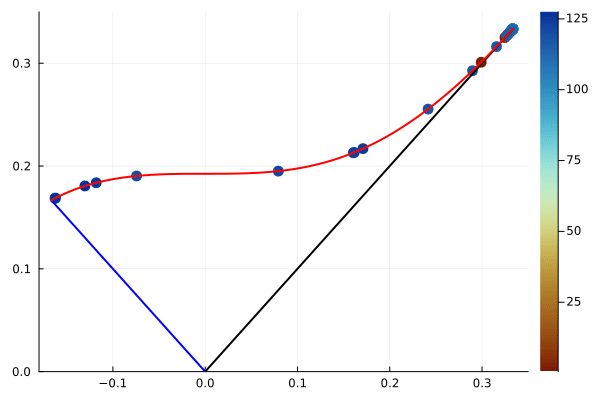

In [115]:
xiList = LinRange(-1/6,1/3,60)

a = Animation()
for i in 1:numFiles
    eigs = uuAlongR2Eigvals(uuAlongRList[:,:,i])
    LumleyCoord = EigVals2LumleyCoord(eigs)
    Plots.plot()
    Plots.scatter!(LumleyCoord[1:128,1],LumleyCoord[1:128,2]; zcolor=rList[1:128], color=:roma, markersize=6, markerstrokewidth=0)
    # Plots.plot!(LumleyCoord[1:128,1],LumleyCoord[1:128,2]; color=:black)
    Plots.plot!([0,-1/6],[0, 1/6],linewidth=2,color=:blue)
    Plots.plot!([0,1/3],[0, 1/3],linewidth=2,color=:black)
    Plots.plot!(xiList, sqrt.(1/27 .+ 2*xiList.^3),linewidth=2,color=:red)
    plt = Plots.plot!(xlimit=(-0.18,0.35), ylimit=(0,0.35),legend=false)
    frame(a,plt)
end
gif(a, computationID*"_"*"qVortexTKESpecAlongR.gif")

In [ ]:
plt = Plots.contourf((0:gridSize[3]-1)/LScale.-4, (0:gridSize[1]-1)/LScale.-4, vortVec[2:end-1,Int(gridSize[2]/2)+1,2:end-1,2], linewidth = 0, color=:RdBu, levels=40, clim=(-4,4), aspect_ratio=:equal, xlim=[0.0,gridSize[1]]/LScale.-4, ylim=[0.0,gridSize[2]]/LScale.-4)

In [ ]:
uruz = flucCylUatCyl[:,:,:,1].*flucCylUatCyl[:,:,:,3]
#uruz = flucCylUatCyl[:,:,:,1].^2 - (flucCylUatCyl[:,:,:,2].^2 + flucCylUatCyl[:,:,:,3].^2)
plt = Plots.contourf(0:255,0:127,flucCylωatCyl[1:128,64,:,2]/2, linewidth = 0, color=:RdBu, levels=40, aspect_ratio=:equal)
plt = Plots.contourf!(0:255,-127:0,reverse(uruz[1:128,64,:]/0.1,dims=1), linewidth = 0, color=:RdBu, levels=40, aspect_ratio=:equal, clim=(-1,1))

In [ ]:
a = Animation()
Plots.plot()
xlll = 20:80
for i ∈ 1:size(flucSpectrum)[2]
    Plots.plot(movmean(flucSpectrum[:,i],1),color=:blue,legend = false,xscale=:log10,yscale=:log10, ylim=(1e-20,10))
    plt = Plots.plot!(xlll, 0.001xlll.^(-5/3))
    frame(a,plt)
end
Plots.plot!(xscale=:log10,yscale=:log10)
gif(a, computationID*"_"*"qVortexTKESpecAlongR.gif")

In [ ]:
Plots.plot(movmean(flucSpectrum[:,80],1),color=:blue, alpha=animAlpha(i,size(flucSpectrum)[2]),legend = false,xscale=:log10,yscale=:log10, ylim=(1e-16,10))
plt = Plots.plot!(xlll, 0.001xlll.^(-5/3))

In [ ]:
using PyPlot

uu = (uCylAtCyl[:,:,128,1].^2+uCylAtCyl[:,:,128,2].^2).^0.5/4
uu = flucCylUatCyl[:,:,128,1].*flucCylUatCyl[:,:,128,3]
uu = ωCylAtCyl[:,:,128,2]
uu = sqrt.(sum(flucCylUatCyl[:,:,128,:].^2,dims=3))[:,:,1]
uu = Statistics.mean(flucCylUatCyl[:,:,:,3],dims=3)[:,:,1]
uu = sqrt.(sum(Statistics.mean(flucCylUatCyl[:,:,:,:], dims=3).^2, dims=4))[:,:,1,1]
uu = log10.(uu)
#uu = Statistics.mean(flucCylUatCyl[:,:,:,:], dims=3)[:,:,1,3]
fig = PyPlot.plt.figure()
ax = fig.add_subplot(111, projection="polar")
pc = PyPlot.plt.contourf(thetaList, rList, uu)
cbar = PyPlot.plt.colorbar(pc)
cbar.set_label("Intensity")
ax[:grid](false)
ax.set_yticklabels([])
PyPlot.plt.savefig("aatt.png")

uu = (uInside[:,:,128,1].^2+uInside[:,:,128,2].^2).^0.5
uu = vortVecInside[:,:,128,3]
pow = 8
fig = PyPlot.plt.figure()
ax = fig.add_subplot(111)
pc = PyPlot.plt.contourf((axes(uu,1))/2^pow, (axes(uu,2))/2^pow, uu'/4)
cbar = PyPlot.plt.colorbar(pc)
cbar.set_label("Intensity")
ax[:grid](false)
PyPlot.plt[:figaspect](1)
PyPlot.plt.savefig("aaaa.png")
matplotlib.pyplot.close()

In [ ]:
matplotlib.pyplot.close()

In [ ]:
println(minimum(uCarteAtCyl[:,:,1,3]))
println(minimum(uu))

println(maximum(uCarteAtCyl[:,:,1,3]))
println(maximum(uu))

In [ ]:
uruxAlongR = Statistics.mean(flucCylUatCyl[:,:,:,1].*flucCylUatCyl[:,:,:,3],dims=[2,3])
uruTAlongR = Statistics.mean(flucCylUatCyl[:,:,:,1].*flucCylUatCyl[:,:,:,2],dims=[2,3])
PuxurAlongR = meanCylωatCyl[:,:,:,2]/2 .*(Statistics.mean(flucCylUatCyl[:,:,:,1].^2,dims=[2,3])+Statistics.mean(flucCylUatCyl[:,:,:,3].^2,dims=[2,3]))

Plots.plot(uruxAlongR[:,1,1],label="u_r u_x")#uCylAtCyl #meanCylUatCyl
Plots.plot!(uruTAlongR[:,1,1],label="u_r u_T")
Plots.plot!(PuxurAlongR[:,1,1],label="Pxr")

In [ ]:
size(flucCylUatCyl)

In [ ]:
ururAlongR = Statistics.mean(flucCylUatCyl[:,:,:,1].^2,dims=[2,3])
ututAlongR = Statistics.mean(flucCylUatCyl[:,:,:,2].^2,dims=[2,3])
uzuzAlongR = Statistics.mean(flucCylUatCyl[:,:,:,3].^2,dims=[2,3])
Plots.plot(ururAlongR[:,1,1],label="u_r u_r")
Plots.plot!(ututAlongR[:,1,1],label="u_T u_T")
Plots.plot!(uzuzAlongR[:,1,1],label="u_z u_z")

In [ ]:
a = Animation()
Plots.plot()
for i in 1:numFiles
    Plots.plot!(rListDimLess, uMeanAxialList[:,i],color=:blue, alpha=animAlpha(i,numFiles),legend = false,ylimit=(-0.1,1.1))
    Plots.plot!(rListDimLess, uMeanAzimuthalList[:,i],color=:red, alpha=animAlpha(i,numFiles),legend = false)
    plt = Plots.plot!(rListDimLess, uMeanRadialList[:,i],color=:green, alpha=animAlpha(i,numFiles),legend = false)
    frame(a,plt)
end
Plots.plot!(legend = false)
Plots.savefig(computationID*"_"*"qVortex_velocityProfiles.png")
Plots.plot!()
gif(a,computationID*"_"*"qVortex_velocityProfiles.gif")

┌ Info: Saved animation to /home/tyhuang/Documents/Github/WaterLily.jl/test/TYTest/ThreeDVortex_256_qVortex_uuDiag.gif
└ @ Plots /home/tyhuang/.julia/packages/Plots/rz1WP/src/animation.jl:156


Plots.AnimatedGif("/home/tyhuang/Documents/Github/WaterLily.jl/test/TYTest/ThreeDVortex_256_qVortex_uuDiag.gif")
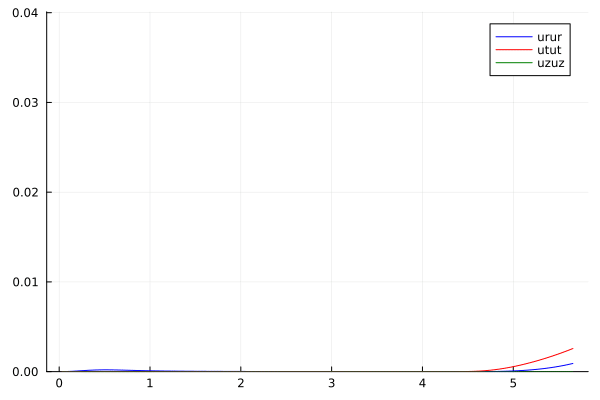

In [44]:
a = Animation()
Plots.plot()
for i in 1:numFiles
    Plots.plot(rListDimLess, uuAlongRList[:,1,i],color=:blue,ylimit=(0,0.0401),label="urur")
    Plots.plot!(rListDimLess, uuAlongRList[:,2,i],color=:red,ylimit=(0,0.0401),label="utut")
    plt = Plots.plot!(rListDimLess, uuAlongRList[:,3,i],color=:green,ylimit=(0,0.0401),label="uzuz")
    frame(a,plt)
end
Plots.plot!(legend = false)
Plots.savefig(computationID*"_"*"qVortex_uuDiag.png")
Plots.plot!()
gif(a,computationID*"_"*"qVortex_uuDiag.gif")


┌ Info: Saved animation to /home/tyhuang/Documents/Github/WaterLily.jl/test/TYTest/ThreeDVortex_256_qVortex_uruz.gif
└ @ Plots /home/tyhuang/.julia/packages/Plots/rz1WP/src/animation.jl:156


Plots.AnimatedGif("/home/tyhuang/Documents/Github/WaterLily.jl/test/TYTest/ThreeDVortex_256_qVortex_uruz.gif")
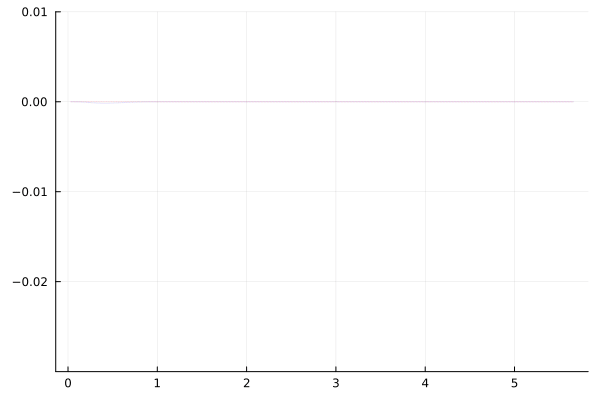

In [34]:
a = Animation()
Plots.plot()
for i in 1:numFiles
    Plots.plot!(rListDimLess, PAlongRList[:,1,i],color=:blue, alpha=animAlpha(i,numFiles),legend = false,ylimit=(-0.03,0.01))
    plt = Plots.plot!(rListDimLess, uuAlongRList[:,6,i],color=:red, alpha=animAlpha(i,numFiles),legend = false)
    frame(a,plt)
end
Plots.plot!(legend = false)
Plots.savefig(computationID*"_"*"qVortex_uruz.png")
Plots.plot!()
gif(a,computationID*"_"*"qVortex_uruz.gif")

┌ Info: Saved animation to /home/tyhuang/Documents/Github/WaterLily.jl/test/TYTest/ThreeDVortex_256_qVortex_urut.gif
└ @ Plots /home/tyhuang/.julia/packages/Plots/rz1WP/src/animation.jl:156


Plots.AnimatedGif("/home/tyhuang/Documents/Github/WaterLily.jl/test/TYTest/ThreeDVortex_256_qVortex_urut.gif")
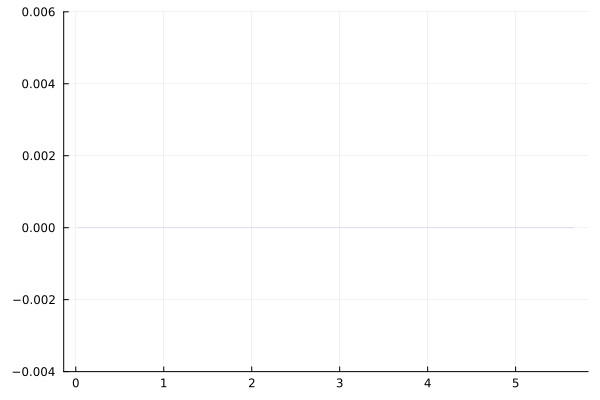

In [37]:
a = Animation()
Plots.plot()
for i in 1:numFiles
    plt = Plots.plot!(rListDimLess, uuAlongRList[:,4,i],color=:blue, alpha=animAlpha(i,numFiles),legend = false,ylimit=(-0.004,0.006))
    frame(a,plt)
end
Plots.plot!(legend = false)
Plots.savefig(computationID*"_"*"qVortex_urut.png")
Plots.plot!()
gif(a,computationID*"_"*"qVortex_urut.gif")

┌ Info: Saved animation to /home/tyhuang/Documents/Github/WaterLily.jl/test/TYTest/ThreeDVortex_256_qVortex_vorticityProfiles.gif
└ @ Plots /home/tyhuang/.julia/packages/Plots/rz1WP/src/animation.jl:156


Plots.AnimatedGif("/home/tyhuang/Documents/Github/WaterLily.jl/test/TYTest/ThreeDVortex_256_qVortex_vorticityProfiles.gif")
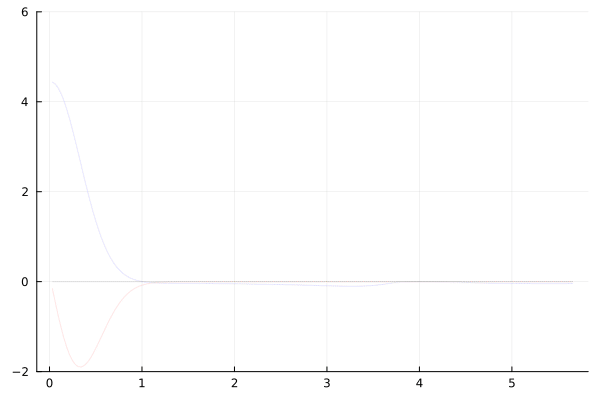

In [19]:
a = Animation()
Plots.plot()
for i in 1:numFiles
    Plots.plot!(rListDimLess, ωMeanAxialList[:,i],color=:blue, alpha=animAlpha(i,numFiles),legend = false,ylimit=(-2,6))
    Plots.plot!(rListDimLess, ωMeanAzimuthalList[:,i],color=:red, alpha=animAlpha(i,numFiles),legend = false)
    plt = Plots.plot!(rListDimLess, ωMeanRadialList[:,i],color=:green, alpha=animAlpha(i,numFiles),legend = false)
    frame(a,plt)
end
Plots.plot!(legend = false)
Plots.savefig(computationID*"_"*"qVortex_vorticityProfiles.png")
Plots.plot!()
gif(a,computationID*"_"*"qVortex_vorticityProfiles.gif")

In [ ]:
a = Animation()
Plots.plot()
for i in 1:numFiles
    plt = Plots.plot!(rListDimLess,tkeRList[:,i],color=:blue, alpha=animAlpha(i,numFiles),legend = false,ylimit=(0,0.7))
    frame(a,plt)
end
Plots.plot!()
Plots.savefig(computationID*"_"*"qVortex_tkeYProfiles.png")

gif(a,computationID*"_"*"qVortex_tkeYProfiles.gif")

In [ ]:
Plots.plot!(rListDimLess, uMeanAxialList[:,i],color=:blue, alpha=animAlpha(i,numFiles),legend = false,ylimit=(-0.1,1.1))
Plots.plot!(rListDimLess, uMeanAzimuthalList[:,i],color=:red, alpha=animAlpha(i,numFiles),legend = false)
plt = Plots.plot!(rListDimLess, uMeanRadialList[:,i],color=:green, alpha=animAlpha(i,numFiles),legend = false)
frame(a,plt)

In [ ]:
maximum(tkePlane)

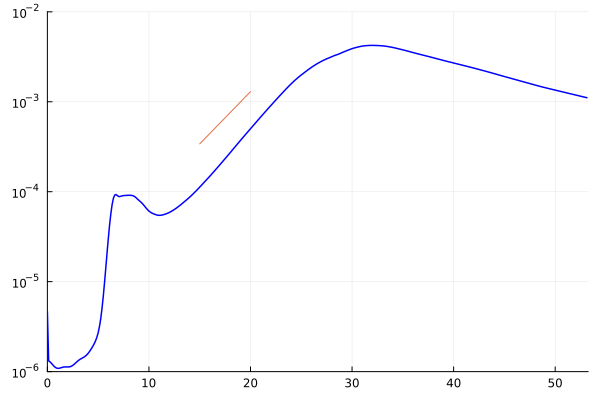

In [41]:
explist = 15:20
expVal = exp.(explist*0.6*0.446 .- 12.0)
Plots.plot(timeListDimLess[1:end-1], tkeList[1:end],yscale=:log10,xlimit=(0,maximum(timeListDimLess)),legend=false,ylimit=(1e-6,1e-2),color=:blue,linewidth=1.5)
Plots.plot!(explist, expVal,yscale=:log10,xlimit=(0,maximum(timeListDimLess)),legend=false)
Plots.savefig(computationID*"_"*"qVortex_TKEEvolutions.png")
Plots.plot!()

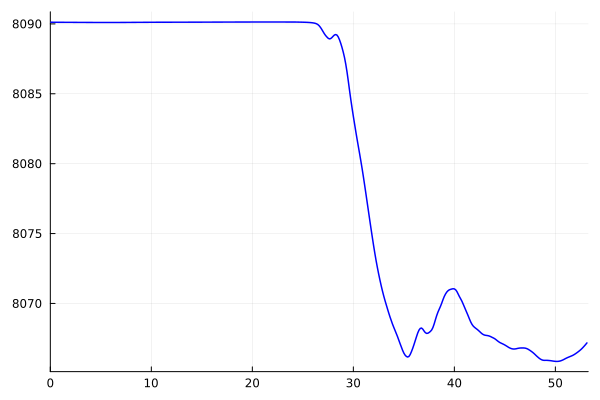

In [39]:
Plots.plot(timeListDimLess[1:end-1], axiMomList[1:end],xlimit=(0,maximum(timeListDimLess)),legend=false,color=:blue,linewidth=1.5)

In [ ]:
a = Animation()
Plots.plot()
for i in 1:numFiles
    plt =  Plots.plot!(kList,vortSpectrumList[:,i],color=:blue, alpha=animAlpha(i,numFiles),xscale=:log10,yscale=:log10,legend = false,ylimit=(1e-9,1))
    frame(a,plt)
end
Plots.plot!(legend = false)
Plots.savefig(computationID*"_"*"qVortex_Enstrophy.png")
Plots.plot!()

gif(a,computationID*"_"*"qVortex_Enstrophy.gif")

In [ ]:
a = Animation()
Plots.plot()
xlll = 20:80
Plots.plot!(xlll, 0.001xlll.^(-5/3))
for i in 1:numFiles
    plt =  Plots.plot!(kList,flucSpectrumList[:,i],color=:blue, alpha=animAlpha(i,numFiles),xscale=:log10,yscale=:log10,legend=false, ylimit=(1e-9,2e-3), yticks = 10. .^(-9:3:-3))
    frame(a,plt)
end
Plots.plot!(legend = false)
Plots.savefig(computationID*"_"*"qVortex_TKESpec.png")
Plots.plot!()

gif(a,computationID*"_"*"qVortex_TKESpec.gif")

In [ ]:
# # processing the velocity data
# ComputeVorticity!(uOriginAll, vortVec)
# vortVec *= TScale
# # vorticityMag = sqrt.(dropdims(sum(vortVec.^2, dims=4), dims=4))
# # ComputeEntrophySpectrum!(vortVec[2:end-1,2:end-1,2:end-1,:], vortSpectrum)
# # vortSpectrum *= 2pi*(2pi*LScale/gridSize[1])
# StaggerToCollocateVel!(uOriginAll, uInside)
# ToCylindricalVel!(uInside, uCyl, rMat, CosThetaMat, SinThetaMat)
# InterpolCylU!(uInside, uCylAtCyl, xCylAtCyl)
# meanCylUatCyl = Statistics.mean(uCylAtCyl, dims=[2,3])
# flucCylUatCyl = uCylAtCyl .- meanCylUatCyl
# # ComputeMeanU!(uCyl, uMeanRadial, uMeanAzimuthal, uMeanAxial, rMat, rGaussianMat)
# ComputeSpectrumFromCylindrical!(flucCylUatCyl, rList, gridSize[3], flucSpectrum)
# # ProjectCylMeanToCartesian!(uMeanFromCyl, uMeanRadial, uMeanAzimuthal, uMeanAxial, rMat, rGaussianMat)
# # ComputeFluc!(uMeanFromCyl, uCyl, uFluc)
# # ComputeEntrophySpectrum!(uFluc, flucSpectrum)
# flucSpectrum *= 2pi*(2pi*LScale/gridSize[1])
# # tkePlane = ComputePlanarTKE!(uFluc)
# # # compute kinetic energy
# # tke = 0.5*sum(uFluc.^2)/prod(gridSize)
# # mke = 0.5*sum(uMeanFromCyl.^2)*gridSize[3]/prod(gridSize)

In [ ]:
a = Animation()
Plots.plot()
for i ∈ 1:size(flucSpectrum)[2]
    plt = Plots.plot!(counts[:,i],color=:blue, alpha=animAlpha(i,size(flucSpectrum)[2]),legend = false,yscale=:log10,xscale=:log10, ylim=(1,820))
    frame(a,plt)
end
Plots.plot!(yscale=:log10,xscale=:log10)
gif(a)